In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from permetrics.regression import RegressionMetric
import os

In [17]:
first_timestamp = '2024-03-18 12:00:00'
last_timestamp = '2024-03-31 00:00:00'

b21 = pd.read_csv('B21.csv')
embassy_sensor = pd.read_csv('embassy_sensor_data.csv')

b21['Timestamp'] = pd.to_datetime(b21['Timestamp']) + pd.Timedelta(hours=7)
embassy_sensor['Date (LT)'] = pd.to_datetime(embassy_sensor['Date (LT)']) + pd.Timedelta(hours=0) #for some readon time offset at airnow is 3 hours

b21 = b21.set_index('Timestamp')
embassy_sensor = embassy_sensor.set_index('Date (LT)')

b21['PM 2.5'] = b21['PM 2.5']*b21['Applied PM 2.5 Custom Calibration Setting - Multiplication Factor']

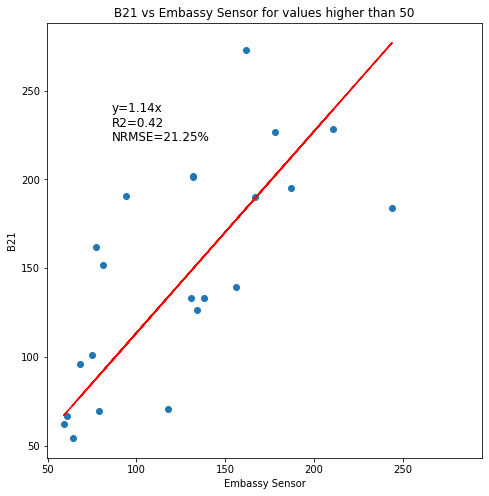

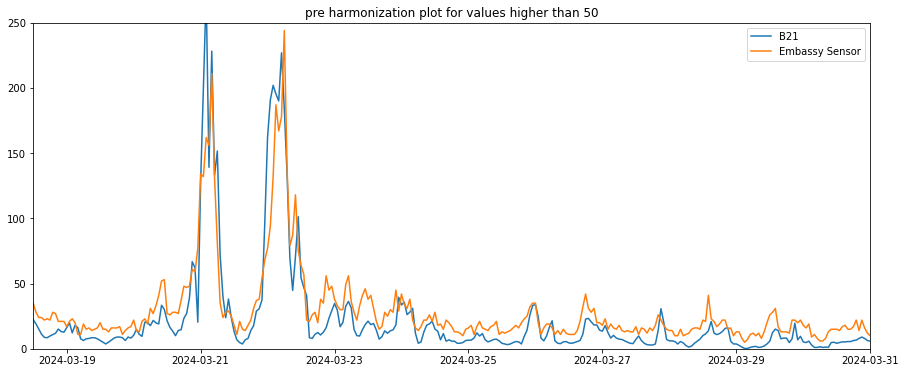

In [19]:
#date range
start = pd.to_datetime(first_timestamp)
end = pd.to_datetime(last_timestamp)
dates = pd.date_range(start=start, end=end, freq='1H')

b21 = b21.loc[start:end]

embassy_sensor = embassy_sensor.loc[start:end]
#print(embassy_sensor['Raw Conc.'])
#print(b21['PM 2.5'])

#fitting
def func(x, a, b):
    return a*x + b

x = embassy_sensor['Raw Conc.'].values
y = b21['PM 2.5'].values
cut1 = x >= 50
cut2 = y >= 50
cut = cut1 & cut2
x[~cut] = np.nan
y[~cut] = np.nan
popt, pcov = curve_fit(func, x[cut], y[cut], bounds=([-np.inf, -0.000001], [np.inf, 0.000001]))

figure = plt.figure(figsize=(10, 8))
plt.scatter(x[cut], y[cut])
plt.plot(x[cut], func(x[cut], *popt), color='red')
plt.ylabel('B21')
plt.xlabel('Embassy Sensor')
plt.axis('square')

#r2 value
residuals = y[cut] - func(x[cut], *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y[cut]-np.mean(y[cut]))**2)
r_squared = 1 - (ss_res / ss_tot)
r2_value = r_squared.round(2)

#nrmse
evaluator = RegressionMetric(y[cut], func(x[cut], *popt))
nrmse = evaluator.normalized_root_mean_square_error(model=2)*100

plt.text(0.3, 0.725, f"y={popt[0].round(2)}x", transform=figure.transFigure, fontsize=12)
plt.text(0.3, 0.7, f"R2={r2_value}", transform=figure.transFigure, fontsize=12)
plt.text(0.3, 0.675, f"NRMSE={nrmse.round(2)}%", transform=figure.transFigure, fontsize=12)
plt.title('B21 vs Embassy Sensor for values higher than 50')
plt.savefig('B21_vs_embassy_sensor_fitting_higher_than_50.png')

#plotting
plt.figure(figsize=(15, 6))
plt.plot(b21['PM 2.5'], label='B21')
plt.plot(embassy_sensor['Raw Conc.'], label='Embassy Sensor')
plt.legend()
plt.ylim(0, 250)
plt.xlim(start, end)
plt.title('pre harmonization plot for values higher than 50')
plt.savefig('pre_harmonization_plot_higher_than_50.png')

In [4]:
evaluator = RegressionMetric(y[cut], func(x[cut], *popt))
nrmse = evaluator.normalized_root_mean_square_error(model=2)  
print(nrmse)  

msd = np.sum((y[cut]-func(x[cut], *popt))**2)/len(y[cut])
rmsd = np.sqrt(msd)
print(rmsd)

print(rmsd/(np.max(y[cut])-np.min(y[cut])))

0.21250120214575102
46.45807531911482
0.21250120214575102


In [22]:
frr = pd.DataFrame({
    'embassy_sensor' : embassy_sensor['Raw Conc.'].values,
    'B21' : b21['PM 2.5'].values
})

frr.to_csv('pm25_vals.csv')